# Operationalizer

**Variables to be operationalized**
- price in USD
- category variable
- ARF (market entry strategy) 
- market exit (deletion of account)
- ARM (time series)
- selling price adjustment (time series)
- proportion of negative feedbacks (time series)


In [1]:
import pandas as pd
import numpy as np

# plotting setup
import matplotlib.pyplot as plt
import matplotlib as mpl 

mpl.rcParams['figure.dpi']= 400
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

import nbextensions
from datetime import datetime
import os
import swifter
import seaborn as sns

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Silkroad2 Item Information

In [2]:
folder = '/Volumes/Extreme SSD/data/final/silkroad2'
file   = 'items.pickle'

df = pd.read_pickle(os.path.join(folder, file))

In [3]:
df['stime_str'] = pd.to_datetime(df.stime_str, format = "%Y-%m-%d").astype('datetime64')

In [4]:
df['rtime_dt'] = pd.to_datetime(df['rtime'], unit = 's')

t_max = df['rtime_dt'].max()
t_min = df['rtime_dt'].min()

print(t_max, t_min)

2015-01-24 17:01:52 2013-11-28 00:02:08


In [5]:
df.describe()

,stime,rating,price,freshness,rtime
count,1.362588e+06,1.362585e+06,1.362588e+06,1.362428e+06,1.362428e+06
mean,1.408474e+09,4.919096e+00,inf,6.879861e+01,1.402530e+09
std,5.049673e+06,5.127793e-01,NaN,8.601725e+01,8.008338e+06
min,1.393134e+09,0.000000e+00,0.000000e+00,0.000000e+00,1.385597e+09
25%,1.402431e+09,5.000000e+00,6.854300e-02,4.000000e+00,1.396987e+09
50%,1.409072e+09,5.000000e+00,1.618560e-01,2.600000e+01,1.402344e+09
75%,1.412592e+09,5.000000e+00,4.261310e-01,1.070000e+02,1.408775e+09
max,1.422119e+09,5.000000e+00,inf,3.420000e+02,1.422119e+09


In [ ]:
s_max = df['stime_str'].max()
s_min = df['stime_str'].min()
s_frq = ((s_max - s_min) / len(df.stime_str.unique())).days

print("The data was collected once every {0} days between {1} and {2}"\
      .format(s_frq, s_min.strftime(format = "%B %d %Y"), s_max.strftime(format = "%B %d %Y")))
print("Within this timespan {0} unique transactions were observed, from a total of {1} unique sellers"\
      .format(len(df), len(df.vendor.unique())))

## Bitcoin Conversion information

In [191]:
# scrape Bitcoin data
url = "https://coinmarketcap.com/currencies/bitcoin/historical-data/?start=20130429&end=20200212"

bitcoin_data = pd.read_html(url)[2]
bitcoin_data.columns =  map(str.lower, bitcoin_data.columns)

In [192]:
bitcoin_data = bitcoin_data[['date', 'open*', 'high', 'low', 'close**']]\
    .assign(date = pd.to_datetime(bitcoin_data['date']),
            mean = bitcoin_data[['high', 'low']].mean(axis=1))\
    .sort_values('date')\
    .reset_index(drop = True)

# define observation period
observation_period = (bitcoin_data['date'] > t_min)\
                      & (bitcoin_data['date'] < t_max)

max_bit = bitcoin_data[observation_period]['mean'].max()
min_bit = bitcoin_data[observation_period]['mean'].min()

In [193]:
bitcoin_data.head()

,date,open*,high,low,close**,mean
0,2013-04-29,134.44,147.49,134.00,144.54,140.745
1,2013-04-30,144.00,146.93,134.05,139.00,140.490
2,2013-05-01,139.00,139.89,107.72,116.99,123.805
3,2013-05-02,116.38,125.60,92.28,105.21,108.940
4,2013-05-03,106.25,108.13,79.10,97.75,93.615


### Fluctiations in bitcoin price

Bitcoin infamously known for its price flucuations. Although the window of observation of this study is way beyond the "bitcoin bubble" occured, there were considerable changes in bitcoin prices overtime.  {{max_bit}}

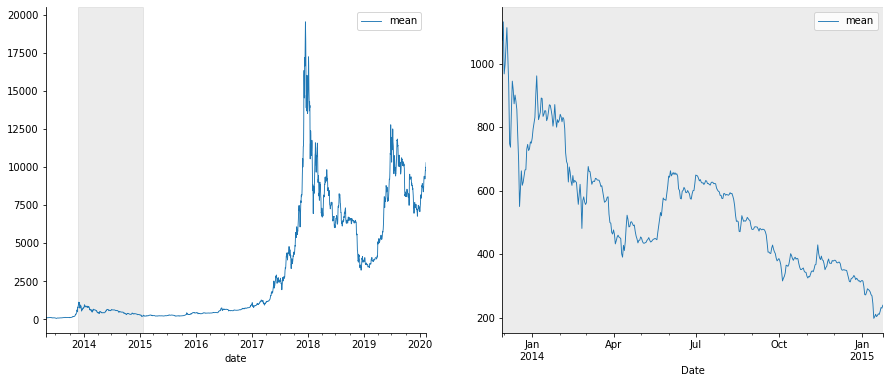

In [194]:
# initiate subplots
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (15, 6))

# all time
bitcoin_data.plot(
    linewidth = .9,
    x = 'date',
    y = 'mean',
    ax = ax1
)

ax1.axvspan(t_min, t_max, color='grey', alpha=0.15)
ax2.set_xlabel('Date')

# time window of observations
bitcoin_data.loc[observation_period].plot(
    linewidth = .9,
    x = 'date',
    y = 'mean',
    ax = ax2
)

ax2.axvspan(t_min, t_max, color='grey', alpha=0.15)
ax2.set_xlabel('Date')

plt.show()

## Converting bitcoin to USD

To make the prices comparable over time points we convert te bitcoin prices to USD. 

In [ ]:
# def get_bitcoin_price(date):
#     if not pd.isnull(date):
#         date = date.strftime("%Y-%m-%d")
#         price = bitcoin_data[bitcoin_data['date'] == date]\
#             .loc[:,'mean']\
#             .values[0]
#     else:
#         price = np.nan
    
#     return price

# # the swifter packages applies mutations more efficiently
# df['price_usd'] = df.swifter.apply(lambda row: row['price'] * get_bitcoin_price(row.rtime_dt), axis = 1)

# # store converted data to temp file to safe time. 
# temp_file = os.path.join(folder, 'temp.pickle')
# df.to_pickle(temp_file)

In [6]:
# load in temporary data file such that data handling is quicker
temp_file = os.path.join(folder, 'temp.pickle')
df = pd.read_pickle(temp_file)

24878


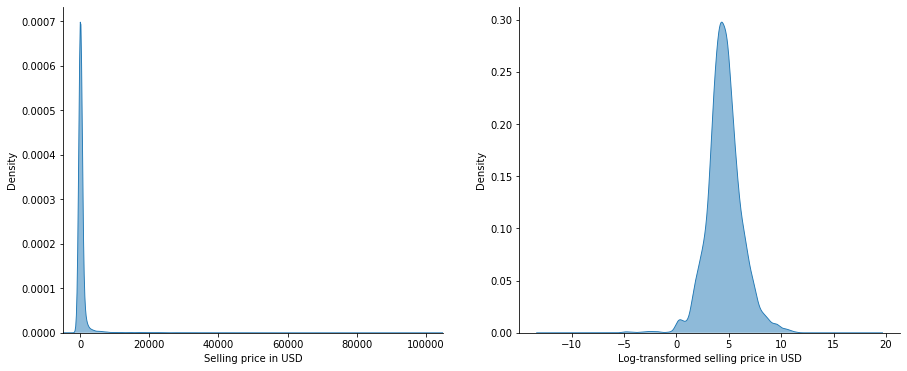

In [7]:
valid_range = (~df['price_usd'].isin([np.nan, np.inf, -np.inf]))\
            & (df['price_usd'] < 100000)\
            & (df['price_usd'] > 0.001)

# initiate subplots
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(15, 6))

# plot not transformed price (right)
df['price_usd'][valid_range]\
    .sample(10000)\
    .plot.kde(linewidth = .9, ax = ax1)

# fill density plot (right)
line = ax1.lines[0].get_data()
ax1.fill_between(line[0], np.zeros(len(line[0])), line[1], alpha = .5);
ax1.set_ylim(bottom = 0)
ax1.set_xlim([-5000, 105000])
ax1.set_xlabel('Selling price in USD')

# plot log transformed price (left)
df['price_usd'][valid_range]\
    .sample(10000)\
    .transform(np.log)\
    .plot.kde(linewidth = .9, ax = ax2)

# fill density plot (left)
line = ax2.lines[0].get_data()
ax2.fill_between(line[0], np.zeros(len(line[0])), line[1], alpha = .5);
ax2.set_ylim(bottom = 0)
ax2.set_xlabel('Log-transformed selling price in USD')

# asses attriation due to invalid values
k_org = len(df['price_usd'][~df['price_usd'].isin([np.nan, np.inf, -np.inf])])
k_val = len(df['price_usd'][valid_range])
print(k_org - k_val)

plt.show()

The prices of products on *silkroad2* are extremely right skewed. Top tier prices range in USD +100,000. `log`-transformation helps to normalized selling prices considerably. Prices higher than USD 100,000 are considered outliers and are therefore excluded from the data. There by 24497 observations were coded as missing, which can be explained by: 
- missingness on the price variable
- `inf` value on the price value
- missingness on data value

In [8]:
# invalid cases are masked
df['price_usd'] = df['price_usd'].mask(~valid_range)

# Rating Time

Rating time (`rtime`) is an instrumental variable to our analysis. Therefore the reliably and quality of this variable is assessed. In our sample a few feedback postings were observed that fall outside of the observation period. These values are backcensored the quality of the data.

In [9]:
df['vendor'] = df.vendor.str.replace("[0-9]{2}$", "").astype('category')

In [10]:
print(df[['stime_str', 'rtime_dt']].describe())

# print number of cases outside of observation period
print("\nbackcensored values because of invalid timestamp: ", 
      sum(((df.rtime_dt - df.stime_str.max()).dt.days > 0) == True))

df['rtime_dt'] = df.rtime_dt.mask((df.rtime_dt - df.stime_str.max()).dt.days > 0)

                  stime_str             rtime_dt
count               1362588              1362428
unique                   57               165305
top     2014-08-27 00:00:00  2014-06-09 20:11:44
freq                 107933                 4940
first   2013-12-20 00:00:00  2013-11-28 00:02:08
last    2014-11-06 00:00:00  2015-01-24 17:01:52

backcensored values because of invalid timestamp:  16231


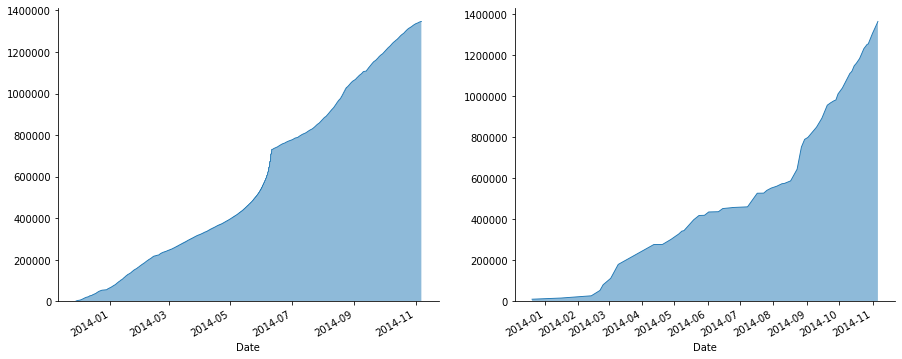

In [11]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(15, 6))

#make cum_dist plot rating time (left)
df\
    .groupby('rtime_dt')['vendor']\
    .count()\
    .cumsum()\
    .plot(ax = ax1, linewidth = .9)
ax1.set_ylim(bottom = 0)

#fill graph
line = ax1.lines[0].get_data()
ax1.fill_between(line[0], np.zeros(len(line[0])), line[1], alpha = .5);
ax1.set_ylim(bottom = 0)
ax1.set_xlabel('Date')


# make cum_dist plot scrape time (right)
df\
    .groupby('stime_str')['vendor']\
    .count()\
    .cumsum()\
    .plot(ax = ax2, linewidth = .9)
ax2.set_ylim(bottom = 0)

#fill graph
line = ax2.lines[0].get_data()
ax2.fill_between(line[0], np.zeros(len(line[0])), line[1], alpha = .5);
ax2.set_ylim(bottom = 0)
ax2.set_xlabel('Date')

plt.show()

The plots above show the cumulative distribution of sample size by rating time (left: `rtime`) and scrape time (right: `stime`). 

#### Cumulative distribution of feedback postings
The left subplot show that the feedbacks posted in our sample are posted gradually over time. This reflects a natural growth distribution of feedback postings in the collected sample. This indicates that the scraping process of the data has proceeded quite reliably. 

#### Cumulative sample size make up per scrape
On the right subplot shows an increasing growth of sample size, which is an inherent characteristic of scraped data. Scrapes at later time points might collect data points that were overlooked in previous scrapes. 

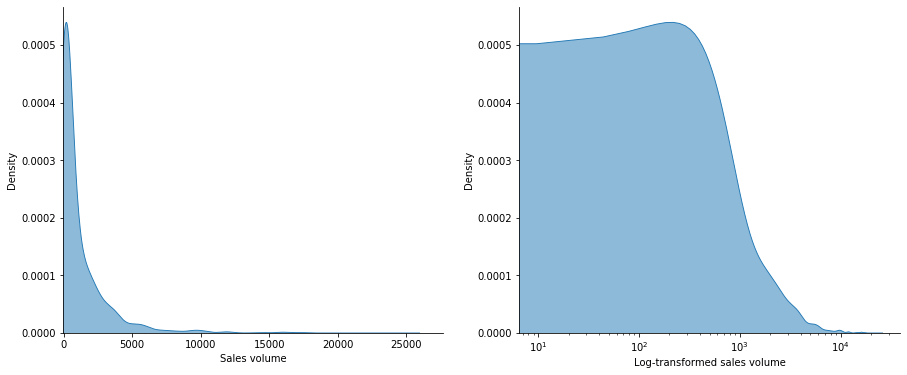

In [12]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = [15,6])

# plots density distribution for sale volume (left)
df['vendor'].value_counts().plot.kde(ax = ax1, linewidth = .9)

# fill graph
line = ax1.lines[0].get_data()
ax1.fill_between(line[0], np.zeros(len(line[0])), line[1], alpha = .5);
ax1.set_ylim(bottom = 0)
ax1.set_xlim(left = -50)
ax1.set(xlabel = 'Sales volume')

# plots density distribution for log-transformed sales volume (right)
df['vendor'].value_counts().plot.kde(ax = ax2, linewidth = .9)
ax2.set_xscale('log')

# fill graph
line = ax2.lines[0].get_data()
ax2.fill_between(line[0], np.zeros(len(line[0])), line[1], alpha = .5);
ax2.set_ylim(bottom = 0)
ax2.set(xlabel = 'Log-transformed sales volume')

plt.show()

# Time of feedback posting

In [13]:
# create time difference between sales for sellers
df.sort_values('rtime')
df['t'] = pd.to_numeric(df.groupby('vendor')['rtime_dt']\
    .transform(lambda x: x - x.min())\
    .dt.days, downcast = 'integer', errors = 'coerce')

# creates time variables for sellers
df['count'] = df.groupby(['vendor']).cumcount()
df['cum_count'] = df.groupby('vendor')['vendor'].transform(np.size)

In [14]:
df = df.sort_index()

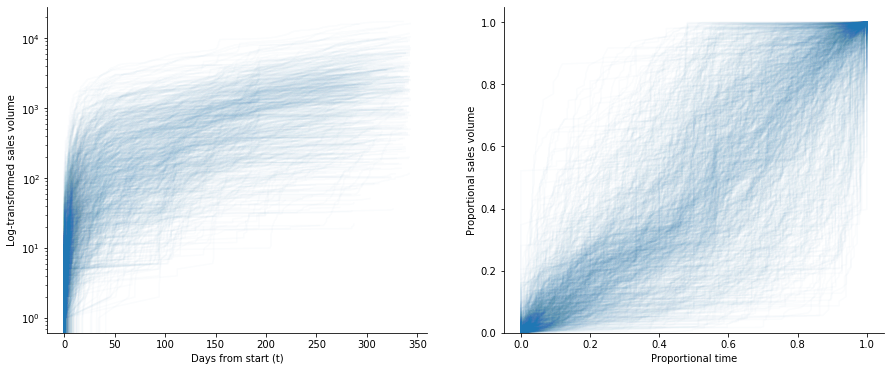

In [15]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = [15,6])

# getting sellers that have had sufficient number of sales
df_ = df[df['cum_count'] >= 20]

vendors = df_['vendor'].unique().tolist()

# iterative plotting for sales trajectory per cryptoseller
for vendor in vendors:
    v = df_[df_['vendor'] == vendor][['count', 't']].dropna()
    y = v['count'].astype(int).sort_values()
    x = v['t'].astype(int).sort_values()
    
    # plots sales trajectory sellers (left)
    ax1.plot(x, y, alpha = .02, c = '#1f77b4')
    ax1.set_yscale('log')
    ax1.set(xlabel = 'Days from start (t)',
            ylabel = 'Log-transformed sales volume')
    
    y = y / v['count'].max().astype(int)
    x = x / v['t'].max().astype(int)
    
    # plots proportional graph (right)
    ax2.plot(x, y, alpha = .02, c = '#1f77b4')
    ax2.set_ylim(bottom = 0)
    ax2.set(xlabel = 'Proportional time',
            ylabel = 'Proportional sales volume')

# display plot
plt.show()

In [16]:
def f(x):
    x['diff'] = x['t']-x['t'].shift(1)
    return x

# calculates time difference between sales
df['diff'] = df\
    .sort_values('t')\
    .groupby('vendor')\
    .apply(f)['diff']\
    .fillna(df['t'])\
    .sort_index()

# creates look-up table with delta_t column
col = df['diff']\
    .groupby([df['vendor'], df['t']])\
    .apply(lambda x: x.mean()).reset_index()
col = col.rename(columns = {'diff' : 'delta_t'})

# merges delta_t on dataframe
df = pd.merge(df, col, on = ['vendor', 't'])

In [190]:
market_entry = df['count'] < 10
t_cut = df[market_entry]['delta_t'].quantile(.25)
p_cut = df[market_entry]['price_usd'].quantile(1/3)
r_cut = df[market_entry]['rating'].quantile(.95)

if 'arf' in df: 
    df = df.drop('arf', axis = 1)

col = df[market_entry]\
    .groupby('vendor')\
    .apply(lambda x: x['delta_t'].mean() < t_cut)\
    .rename('arf')

df = df.merge(col, on = 'vendor')

if 'arf_1' in df: 
    df = df.drop('arf_1', axis = 1)

col = df[market_entry]\
    .groupby('vendor')\
    .apply(lambda x: (x['delta_t'].mean() < t_cut and (x['price_usd'].mean() < p_cut)))\
    .rename('arf_1')

df = df.merge(col, on = 'vendor')

if 'arf_2' in df: 
    df = df.drop('arf_2', axis = 1)

col = df[market_entry]\
    .groupby('vendor')\
    .apply(lambda x: (x['delta_t'].mean() < t_cut and\
                     ((x['price_usd'].mean() < p_cut) and\
                     (x['rating'].mean() >= r_cut))))\
    .rename('arf_2')

df = df.merge(col, on = 'vendor')

In [183]:
df[df['count'] == 1].arf_2.sum()

35

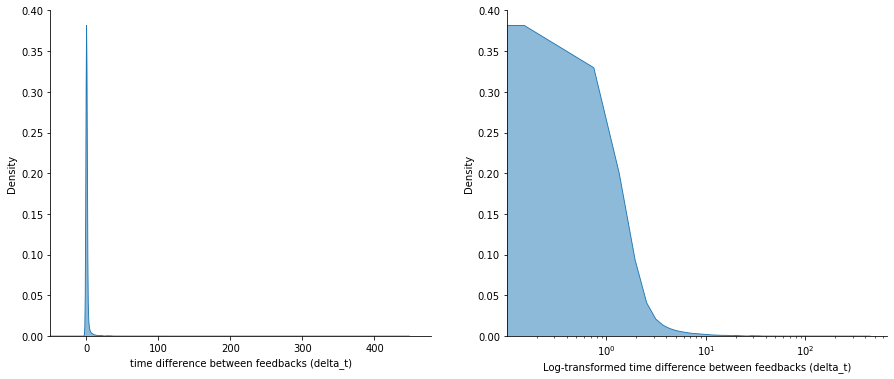

In [184]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = [15,6])

# make distribution plot w/o transformation (left)
df[market_entry]['delta_t'].plot.kde(ax = ax1, linewidth = .9)

# fill graph
line = ax1.lines[0].get_data()
ax1.fill_between(line[0], np.zeros(len(line[0])), line[1], alpha = .5);

# set axes
ax1.set_ylim(bottom = 0)
ax1.set_xlim(left = -50)
ax1.set(xlabel = 'time difference between feedbacks (delta_t)')

# make distribution plot with log transformation (right)
df[market_entry]['delta_t'].plot.kde(ax = ax2, linewidth = .9)
ax2.set_xscale('log')

# fill graph
line = ax2.lines[0].get_data()
ax2.fill_between(line[0], np.zeros(len(line[0])), line[1], alpha = .5);

# set axes
ax2.set_ylim(bottom = 0)
ax2.set(xlabel = 'Log-transformed time difference between feedbacks (delta_t)')

plt.show()

The plots above present the density distributions of time difference between posted feedbacks. As expected, these distributions are extremely left skewed. **cut-off values need to be determined to excluded univariate outliers**

### Visual inspection sales trajectory of ARF sellers

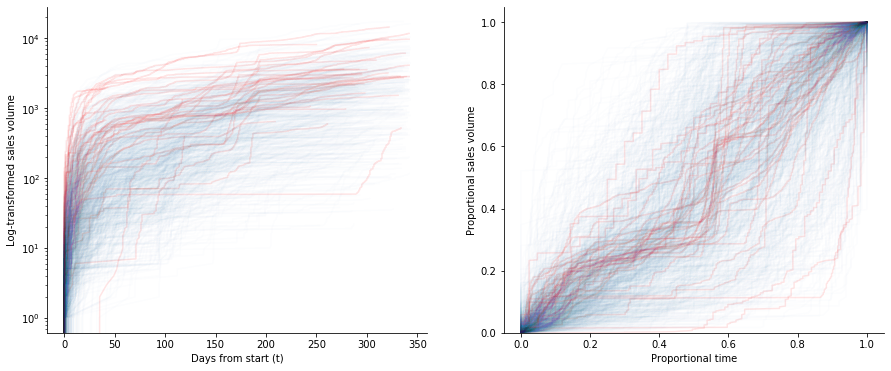

In [185]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = [15,6])

# getting sellers that have had sufficient number of sales
df_ = df[df['cum_count'] >= 20]

vendors = df_['vendor'].unique().tolist()
colors = {True  : 'red',
          False : '#1f77b4'}
alphas = {True  : .1,
          False : .01}

# iterative plotting for sales trajectory of cryptosellers
for vendor in vendors:
    v = df_[df_['vendor'] == vendor][['count', 't', 'arf_2']].dropna()
    y = v['count'].astype(int).sort_values()
    x = v['t'].astype(int).sort_values()
    c = v['arf_2'].map(colors).to_list()[0]
    a = v['arf_2'].map(alphas).to_list()[0]
    
    # Plots sales trajectory 
    ax1.plot(x, y, alpha = a, c = c)
    ax1.set_yscale('log')
    ax1.set(xlabel = 'Days from start (t)',
            ylabel = 'Log-transformed sales volume')
    
    y = y / v['count'].max()
    x = x / v['t'].max()
    
    # Plots proportional sales trajectory
    ax2.plot(x, y, alpha = a, c = c)
    ax2.set_ylim(bottom = 0)
    ax2.set(xlabel = 'Proportional time',
            ylabel = 'Proportional sales volume')

# display plot
plt.show()

### Negative Ratings

In [198]:
(df['rating'] == 5).mean()

0.9702257544772422

In [258]:
# in terms of expanding proportion of negative ratings
n_ = df\
    .sort_values('rtime')\
    .groupby('vendor')\
    .apply(lambda x : x['rating'] != 5)\
    .expanding(min_periods = 1).mean()\
    .reset_index(drop = True)\
    .rename('neg_rating')

# concat negative rating if not already concatted to dataframe
if 'neg_rating' not in df:
    df = pd.concat([df.sort_values('rtime'), n_], axis = 1)

### Identification Validation

In the section below the classification of sellers will be tested by against an Principal component structure taking 

In [259]:
from sklearn.preprocessing import power_transform
from sklearn.preprocessing import StandardScaler

t_ = df[market_entry].copy()[['vendor', 'arf', 'arf_1', 'arf_2']].reset_index(drop = True)

# features (asserting normal distributions)
f_ = df[market_entry].copy()[['delta_t', 'price', 't', 'rating', 'neg_rating']]\
    .assign(
        price = lambda df_copy: power_transform(df_copy.price.to_numpy().reshape(-1, 1), 'yeo-johnson'),
        delta_t = lambda df_copy: power_transform(df_copy.delta_t.to_numpy().reshape(-1, 1), 'yeo-johnson'))\
    .reset_index(drop = True)

# standardization of features (improves accuracy)
f_[['delta_t', 'price', 't']] = pd.DataFrame(StandardScaler().fit_transform(f_[['delta_t', 'price', 't']]),
             columns = ['delta_t', 'price', 't'])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/_methods.py:121: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


In [187]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2) # ARF and not ARF

f_pca = pd.DataFrame(pca.fit_transform(f_),
             columns = ['x', 'y'])

test = pd.concat([t_, f_pca], axis = 1)
test = pd.concat([test[['vendor', 'arf', 'arf_1', 'arf_2']]\
              .drop_duplicates()\
              .reset_index(drop = True),
          test\
              .groupby('vendor')[['x','y']]\
              .mean().reset_index(drop = True)],
         axis = 1)

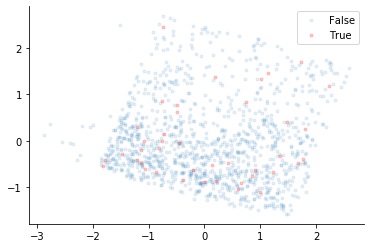

In [188]:
groups = test.groupby('arf_2')
colors = {True  : 'red',
          False : '#1f77b4'}
alphas = {True  : .2,
          False : .1}

# Plot
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    a = group['arf_2'].map(alphas).to_list()[0]
    c = group['arf_2'].map(colors).to_list()[0]
    ax.plot(group.x, group.y, marker='.', linestyle='', c = c, label = name, alpha = a)

ax.legend()

plt.show()

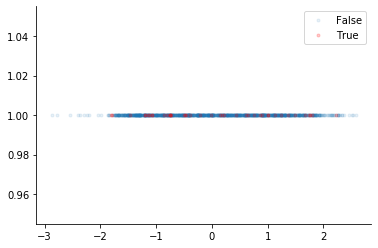

In [189]:
pca   = PCA(n_components = 1)
f_pca = pd.DataFrame(pca.fit_transform(f_),
             columns = ['x'])\
    .assign(y = 1)

test = pd.concat([t_, f_pca], axis = 1)
test = pd.concat([test[['vendor', 'arf', 'arf_1', 'arf_2']]\
              .drop_duplicates()\
              .reset_index(drop = True),
          test\
              .groupby('vendor')[['x','y']]\
              .mean().reset_index(drop = True)],
         axis = 1)

groups = test.groupby('arf_2')
colors = {True  : 'red',
          False : '#1f77b4'}
alphas = {True  : .2,
          False : .1}

# Plot
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    a = group['arf_2'].map(alphas).to_list()[0]
    c = group['arf_2'].map(colors).to_list()[0]
    ax.plot(group.x, group.y, marker='.', linestyle='', c = c, label = name, alpha = a)

ax.legend()

In [104]:
# cat_file = '/Volumes/Extreme SSD/data/final/silkroad2/categories.pickle'
# categories = pd.read_pickle(cat_file)

In [ ]:
# categories.columns = ['item', 'vendor',
#                       'location', 'area', 'price', 'category']

In [ ]:
# df = df.drop('category', axis = 1)

In [ ]:
# if 'category' not in df.columns:
#     df['flag'] = df.rtime_dt.astype('category')
#     df = pd.merge(df, 
#                   categories[['item', 'category']], 
#                   on = ['item'],
#                   how = 'left')\
#         .drop_duplicates(['vendor', 'flag', 'location', 'feedback', 'rating'])\
#         .drop('flag', axis = 1)\
#         .reset_index(drop = True)

# df.sample(5)

In [ ]:
# # count number of missing values in categories column 
# # 246454 values are empty, which indicates that a few 
# # items could not be matched to a category
# df.category.isna().sum()

# # an alternative approach would be to reparse the items
# # the designated items after closer inspections is the
# # at the first <div> {class: categories}. (time consuming)

In [ ]:
# df.shape

# Market Exit

In [ ]:
df = df.drop('last_sale', axis = 1)

In [ ]:
# getting sellers that have had sufficient number of sales
df_ = df.copy()

col = df_.t\
    .groupby(df_.vendor)\
    .apply(lambda x: int(x.max()))\
    .reset_index()\
    .rename(columns = {'t': 'last_sale'})

In [ ]:
df_ = pd.merge(df_, col, on = 'vendor')

In [ ]:
df_

In [ ]:
vendors = df_[['vendor', 'arf_1', 'last_sale', 'stime_str']]\
    .drop_duplicates()\
    .reset_index(drop = True)\
    .assign(exit = lambda x: x['stime_str'] != x['stime_str'].max())\
    .drop('stime_str', axis = 1)\
    .drop_duplicates(keep = 'last')\
    .reset_index(drop = True)

In [ ]:
from lifelines import KaplanMeierFitter

# set groups
did_arf = (vendors['arf_1'] == True)
no_arf = (vendors['arf_1'] == False)

# plot for ARF sellers
kmf = KaplanMeierFitter()
kmf.fit(durations=vendors.last_sale[did_arf],
        event_observed=vendors.exit[did_arf],
        label='ARF',)
a1 = kmf.plot()

# plot for no_ARF sellers
kmf.fit(durations=vendors.last_sale[no_arf],
        event_observed=vendors.exit[no_arf],
        label='NO ARF',)
a1 = kmf.plot(ax=a1)

plt.show()

In [ ]:
subset = ['vendor', 'flag', 'location', 'feedback', 'rating']

# merge 
df = pd.merge(df, 
        vendors, 
        on = ['vendor', 'arf'],
        how = 'inner')\
    .assign(flag = df.rtime_dt.dt.date.astype('category'))\
    .drop_duplicates(subset = subset)\
    .drop('flag', axis = 1)

In [ ]:
del df_, vendors, a1, subset